# I. Set-up

In [22]:
# Standard imports
import pandas as pd
import numpy as np
import json

# Geospatial processing packages
from matplotlib import pyplot as plt
from shapely import wkt
import geopandas as gpd
import geopandas as gpd
import rasterio # as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling

# import geemap
# import geemap.eefolium as emap

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl

In [23]:
# # Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# II. Extracting NOAH Hazard Level Data

## A. Setting up Administrative Boundary Data

In [24]:
# Read Lacuna Administrative Boundary Data
adm_fn = '/home/cczablan1/projects/lacuna-fund-climate-health/data/target_admin_boundaries/target_admin_bounds.shp'
adm_gdf = gpd.read_file(adm_fn).to_crs('EPSG:32651')

# Apply Geometry Fix
adm_gdf["geometry"] = adm_gdf["geometry"].apply(lambda x: wkt.loads(wkt.dumps(x, rounding_precision=4)))

# Compute Area
adm_gdf['brgy_total_area_sqkm'] = adm_gdf.geometry.area.div(1000000).round(4)
adm_gdf.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,brgy_total_area_sqkm
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((214045.003 1776779.832, 214019.452 1...",1.0216
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((214708.019 1775166.057, 214717.717 1...",1.0440
2,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Pantal,PH015518022,"POLYGON ((216189.272 1777401.028, 216215.228 1...",3.2625
3,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Barangay I (T. Bugallon),PH015518024,"POLYGON ((215436.528 1775726.907, 215437.143 1...",0.1814
4,Region III,PH030000000,Nueva Ecija,PH034900000,Palayan City,PH034919000,Imelda Valley,PH034919017,"POLYGON ((298678.543 1723395.559, 299145.784 1...",6.3369


In [26]:
lacuna_provinces = ["Albay", "Cebu", "DavaoDelSur", "Iloilo", "Leyte",
                    "MetroManila", "MetroManila", "MetroManila",
                    "MisamisOriental", "Pangasinan", "NuevaEcija", "ZamboangaDelSur"]

In [27]:
lacuna_cities = ["Legazpi City", "Mandaue City", "Davao City", "Iloilo City", "Tacloban City",
                 "City of Muntinlupa", "City of Mandaluyong", "City of Navotas",
                 "Cagayan de Oro City", "Dagupan City", "Palayan City", "Zamboanga City"]

## B. 100-year Flood Hazard 

### 1. Extracting Hazard Level Percent Area

Compute the percent area of each 25-year flood hazard level per baranggay across the Lacuna Cities. 


In [29]:
# Setup an empty list that will eventually contain all the Lacuna City Dataframes with ammended Flood Hazard Area Data
city_gdf_list = []
  
# Target Output Columns
pivot_city_column_names_100yr_fl = ['brgy_pct_area_flood_hazard_25yr_low',
                                'brgy_pct_area_flood_hazard_25yr_med', 
                                'brgy_pct_area_flood_hazard_25yr_high']  

# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces[:1]):
  print(count,province, lacuna_cities[count])

  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial 100-Year Flood Hazard Data 
  fl_hzrd_fn = f'/home/cczablan1/projects/lacuna-fund-climate-health/data/NOAH-Flood-Hazard/100-year/{province}_Flood_100year.shp'
  fl_hzrd_gdf = gpd.read_file(fl_hzrd_fn).to_crs('EPSG:32651')

  # Clip Flood Hazard Data with Lacuna City <i>'s boundary.
  clipped_fl_hzrd_gdf = gpd.clip(fl_hzrd_gdf, city_gdf)

  # Get Intersection of each Hazard with each Baranggay
  overlay_city_fl_hzrd_gdf = gpd.overlay(city_gdf, clipped_fl_hzrd_gdf, how='intersection', keep_geom_type=False)

  # Calculate the area (inkm2) of the resulting intersecting polygons 
  overlay_city_fl_hzrd_gdf['area'] = overlay_city_fl_hzrd_gdf.geometry.area.div(1000000)

  # Aggregate the area of the intersecting polygons by Baranggay using a Pivot Table 
  pivot_city_gdf = overlay_city_fl_hzrd_gdf.pivot_table(index='ADM4_EN', columns='Var', values='area', aggfunc=np.sum)

  # Rename Columns for Readability. Note that the values are still in km2.
  pivot_city_gdf.columns = pivot_city_column_names_100yr_fl

  # display(pivot_city_gdf)
  
  # Merge the computed pivot table data to the original city administrative data
  city_gdf = city_gdf.merge(pivot_city_gdf, on='ADM4_EN', how='left') 

  # Compute Percent Area out of Baranggay Area
  city_gdf[pivot_city_column_names_100yr_fl] = city_gdf[pivot_city_column_names_100yr_fl].div(city_gdf.brgy_total_area_sqkm, axis=0)*100
  # display(city_gdf.iloc[:,10:])

  # Add city data to list of city dataframes
  city_gdf_list.append(city_gdf)

# Concatenate Lists of Lacuna City with Hazard Data Dataframes
fl_100_year_gdf = pd.concat(city_gdf_list)
fl_100_year_gdf.head()

0 Albay Legazpi City


,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,brgy_total_area_sqkm,brgy_pct_area_flood_hazard_25yr_low,brgy_pct_area_flood_hazard_25yr_med,brgy_pct_area_flood_hazard_25yr_high
0,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 45 - Dita (Bgy. 51),PH050506053,"POLYGON ((579752.343 1458208.276, 580219.811 1...",0.8428,18.770255,0.688449,0.090723
1,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 62 - Homapon (Bgy. 55),PH050506056,"POLYGON ((582204.624 1447546.937, 582206.580 1...",7.0818,3.306187,5.833723,6.514679
2,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 10 - Cabugao,PH050506072,"POLYGON ((579556.773 1452590.900, 579560.114 1...",0.0335,4.426383,1.878421,NaN
3,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 23 - Imperial Court Subd. (Pob.),PH050506020,"POLYGON ((581731.582 1452914.659, 581758.664 1...",0.0621,7.036058,68.688661,22.837934
4,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 40 - Cruzada (Bgy. 52),PH050506051,"POLYGON ((580282.649 1455133.588, 580380.407 1...",1.4442,17.295738,5.928618,0.118485


### 2. Plotting Flood Hazard Maps

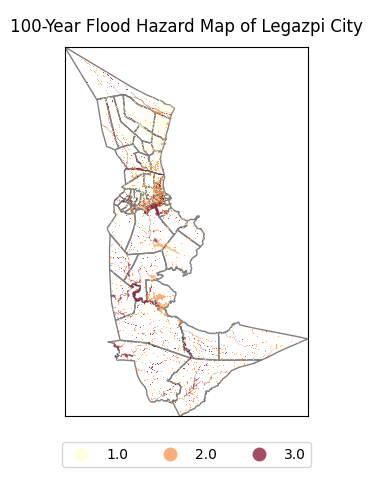

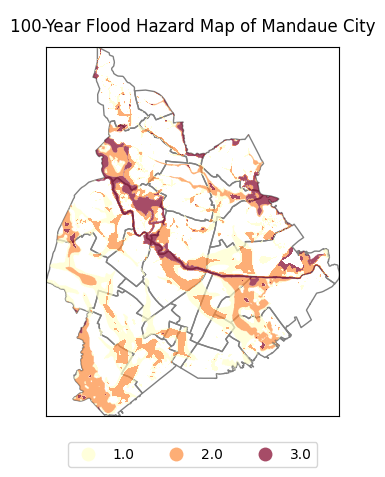

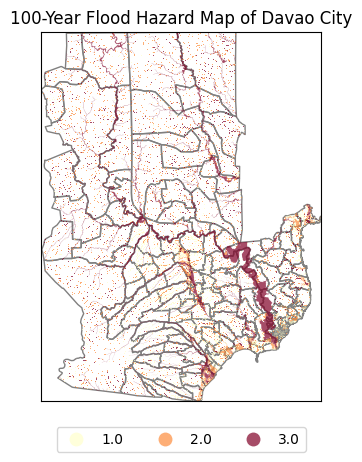

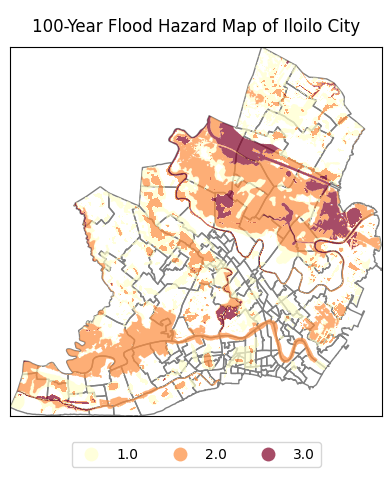

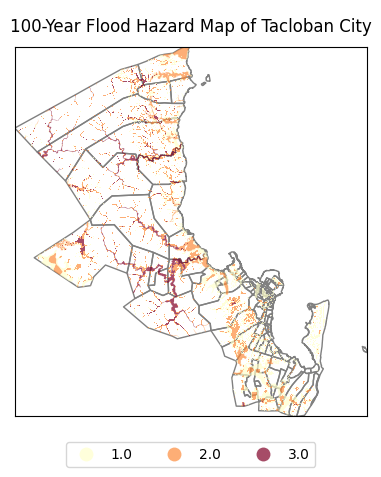

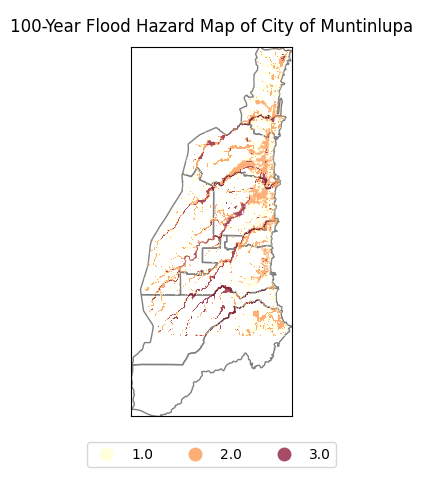

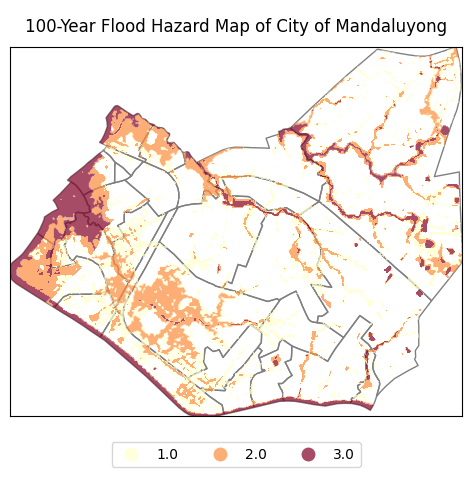

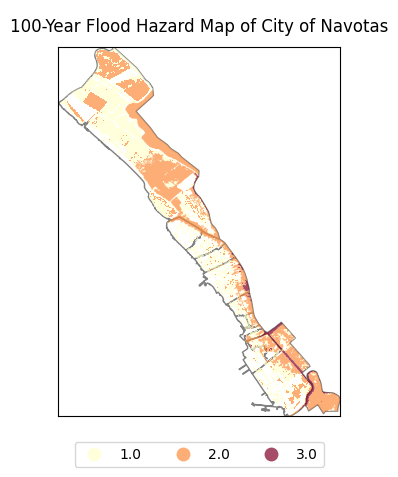

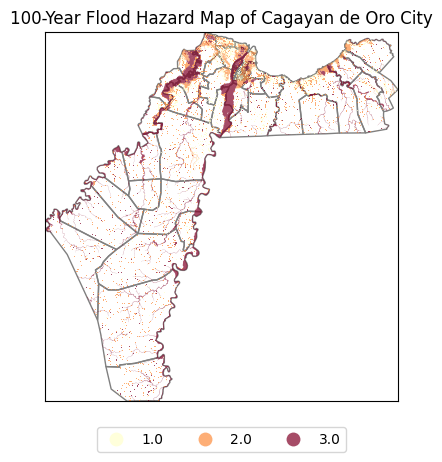

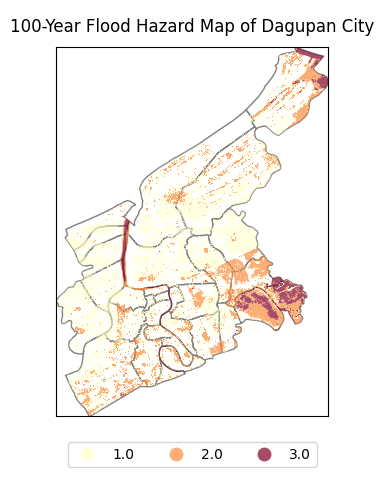

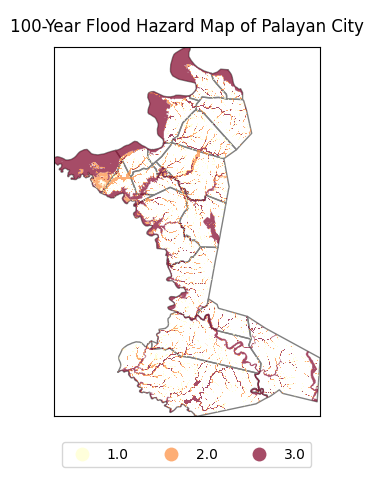

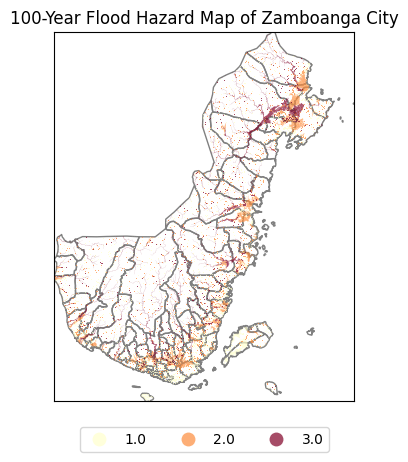

In [ ]:
# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces):
  # print(count,province, lacuna_cities[count])
 
  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial 100-Year Flood Hazard Data 
  fl_hzrd_fn = f'/content/drive/My Drive/Lacuna/FloodHazard/100-year/{province}_Flood_100year.shp'
  fl_hzrd_gdf = gpd.read_file(fl_hzrd_fn).to_crs('EPSG:32651')
  
  # Clip Flood Hazard Data with Lacuna City <i>'s boundary.
  clipped_fl_hzrd_gdf = gpd.clip(fl_hzrd_gdf, city_gdf)

  # Create the figure and axes
  fig, ax = plt.subplots()

  # Plot the Administrative Boundary Basemap (first layer)
  city_gdf.plot(ax=ax, facecolor="none", edgecolor='gray')

  # Crop the visualization to the extent of the first layer
  ax.set_xlim(city_gdf.total_bounds[0], city_gdf.total_bounds[2])
  ax.set_ylim(city_gdf.total_bounds[1], city_gdf.total_bounds[3])
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

  # Plot the second layer (flood hazard)
  clipped_fl_hzrd_gdf.plot(ax=ax, column='Var', categorical=True, cmap='YlOrRd', alpha=0.7, legend=True,
                  legend_kwds={'loc': 'upper center',
                                'bbox_to_anchor' : (0.5, -0.05),
                                'ncol': 3})

  # Set Title
  plt.title("100-Year Flood Hazard Map of "+lacuna_cities[count])

  # Save the figure
  # plt.savefig(f'/content/drive/My Drive/Lacuna/Plots/{lacuna_cities[count]}_Flood_100_year.png')

  # Show the plot
  plt.show()


## C. 25-year Flood Hazard

### 1. Extracting Hazard Level Percent Area

Compute the percent area of each 25-year flood hazard level per baranggay across the Lacuna Cities. 

In [30]:
# Setup an empty list that will eventually contain all the Lacuna City Dataframes with ammended Flood Hazard Area Data
city_gdf_list = []
  
# Target Output Columns
pivot_city_column_names_25yr_fl = ['brgy_pct_area_flood_hazard_25yr_low',
                                'brgy_pct_area_flood_hazard_25yr_med', 
                                'brgy_pct_area_flood_hazard_25yr_high']  

# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces[:1]):
  print(count,province, lacuna_cities[count])

  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial 25-Year Flood Hazard Data 
  fl_hzrd_fn = f'/home/cczablan1/projects/lacuna-fund-climate-health/data/NOAH-Flood-Hazard/25-year/{province}_Flood_25year.shp'
  fl_hzrd_gdf = gpd.read_file(fl_hzrd_fn).to_crs('EPSG:32651')

  # Clip Flood Hazard Data with Lacuna City <i>'s boundary.
  clipped_fl_hzrd_gdf = gpd.clip(fl_hzrd_gdf, city_gdf)

  # Get Intersection of each Hazard with each Baranggay
  overlay_city_fl_hzrd_gdf = gpd.overlay(city_gdf, clipped_fl_hzrd_gdf, how='intersection', keep_geom_type=False)

  # Calculate the area (inkm2) of the resulting intersecting polygons 
  overlay_city_fl_hzrd_gdf['area'] = overlay_city_fl_hzrd_gdf.geometry.area.div(1000000)

  # Aggregate the area of the intersecting polygons by Baranggay using a Pivot Table 
  pivot_city_gdf = overlay_city_fl_hzrd_gdf.pivot_table(index='ADM4_EN', columns='Var', values='area', aggfunc=np.sum)
  
  # Rename Columns for Readability. Note that the values are still in km2.
  pivot_city_gdf.columns = pivot_city_column_names_25yr_fl

  # display(pivot_city_gdf)
  
  # Merge the computed pivot table data to the original city administrative data
  city_gdf = city_gdf.merge(pivot_city_gdf, on='ADM4_EN', how='left') 

  # Compute Percent Area out of Baranggay Area
  city_gdf[pivot_city_column_names_25yr_fl] = city_gdf[pivot_city_column_names_25yr_fl].div(city_gdf.brgy_total_area_sqkm, axis=0)*100
  # display(city_gdf.iloc[:,10:])

  # Add city data to list of city dataframes
  city_gdf_list.append(city_gdf)

# Concatenate Lists of Lacuna City with Hazard Data Dataframes
fl_25_year_gdf = pd.concat(city_gdf_list)
fl_25_year_gdf.head()



0 Albay Legazpi City


,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,brgy_total_area_sqkm,brgy_pct_area_flood_hazard_25yr_low,brgy_pct_area_flood_hazard_25yr_med,brgy_pct_area_flood_hazard_25yr_high
0,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 45 - Dita (Bgy. 51),PH050506053,"POLYGON ((579752.343 1458208.276, 580219.811 1...",0.8428,2.035394,0.572573,0.059326
1,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 62 - Homapon (Bgy. 55),PH050506056,"POLYGON ((582204.624 1447546.937, 582206.580 1...",7.0818,NaN,NaN,NaN
2,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 10 - Cabugao,PH050506072,"POLYGON ((579556.773 1452590.900, 579560.114 1...",0.0335,3.272631,1.791045,NaN
3,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 23 - Imperial Court Subd. (Pob.),PH050506020,"POLYGON ((581731.582 1452914.659, 581758.664 1...",0.0621,17.267672,70.615647,5.903528
4,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 40 - Cruzada (Bgy. 52),PH050506051,"POLYGON ((580282.649 1455133.588, 580380.407 1...",1.4442,13.789808,4.550538,0.047622


### 2. Plotting Flood Hazard Maps

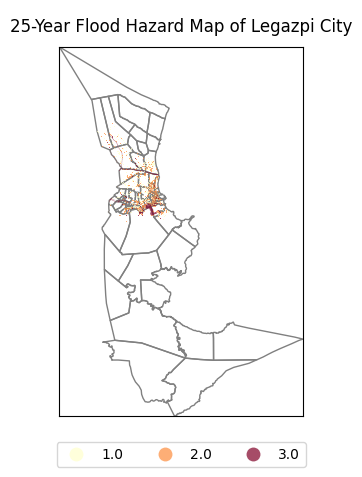

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


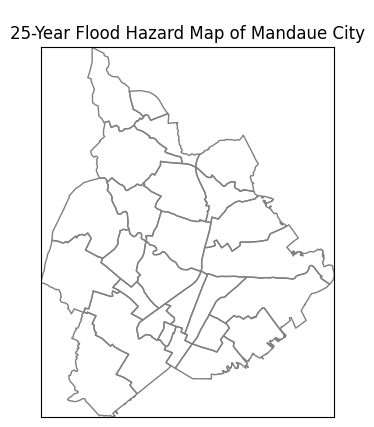

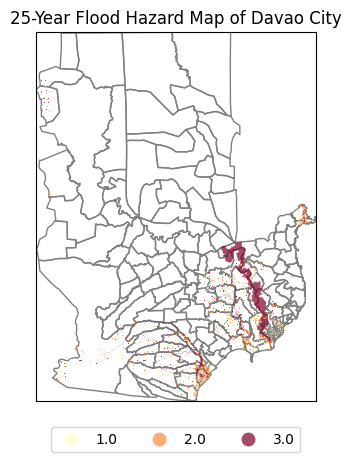

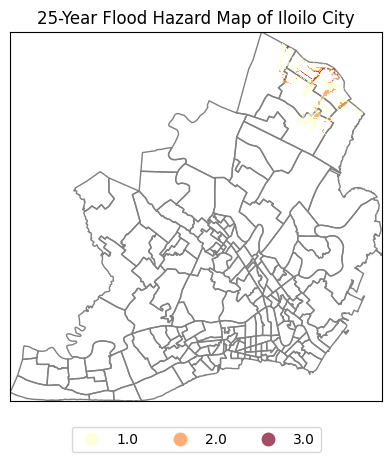

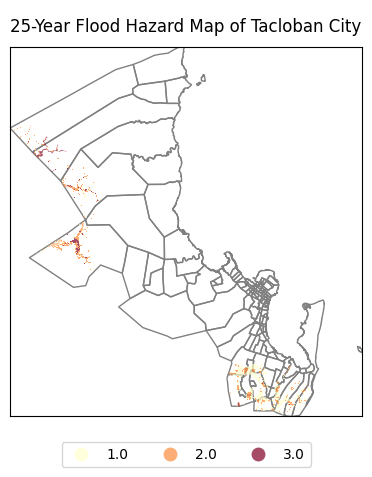

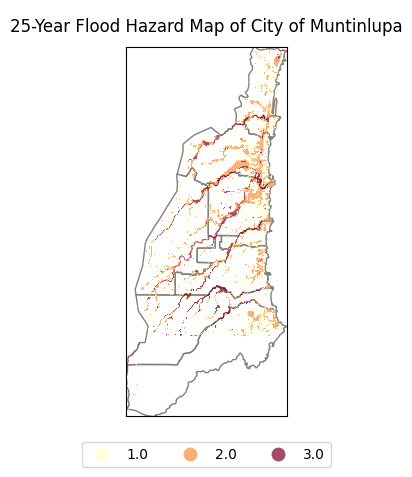

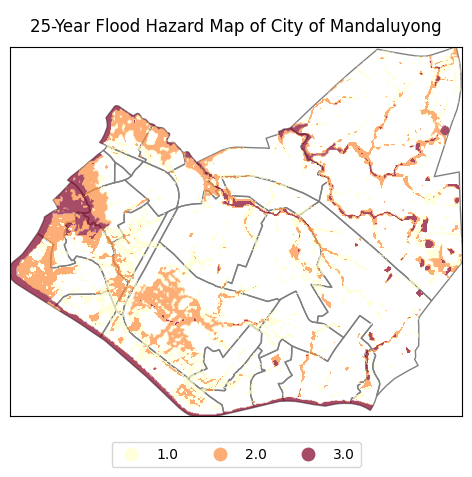

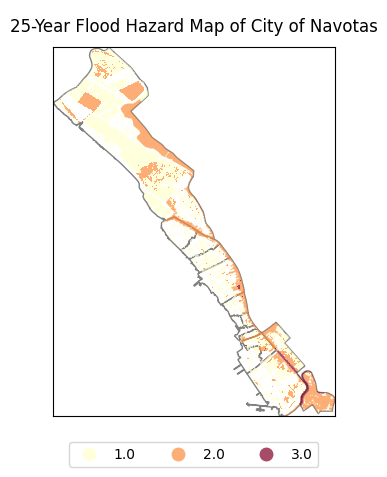

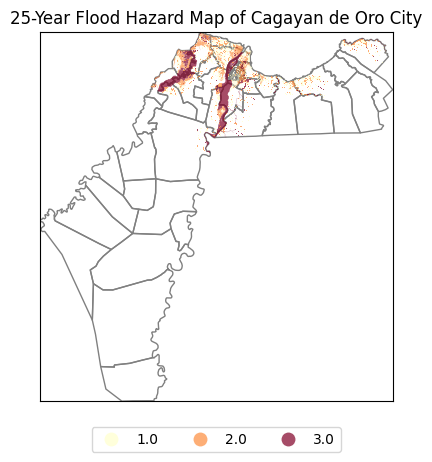

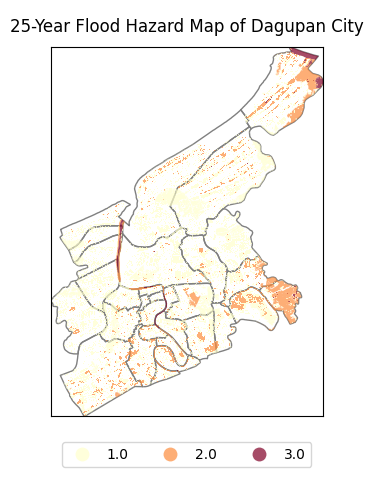

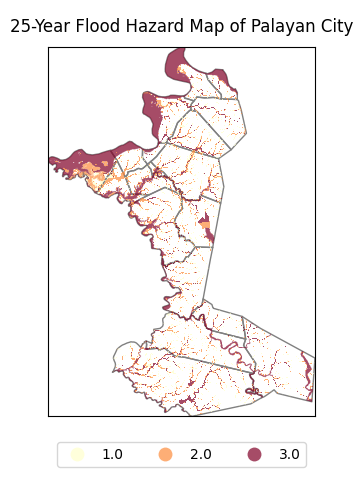

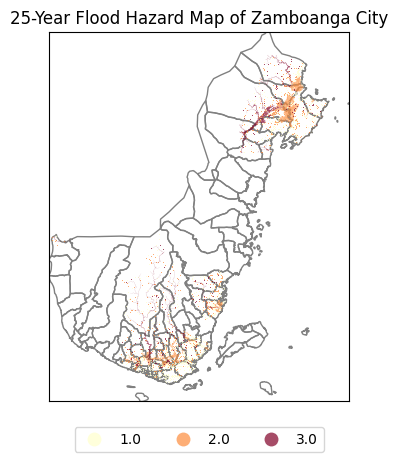

In [ ]:
# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces):
  # print(count,province, lacuna_cities[count])
 
  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial 25-Year Flood Hazard Data 
  fl_hzrd_fn = f'/content/drive/My Drive/Lacuna/FloodHazard/25-year/{province}_Flood_25year.shp'
  fl_hzrd_gdf = gpd.read_file(fl_hzrd_fn).to_crs('EPSG:32651')
  
  # Clip Flood Hazard Data with Lacuna City <i>'s boundary.
  clipped_fl_hzrd_gdf = gpd.clip(fl_hzrd_gdf, city_gdf)

  # Create the figure and axes
  fig, ax = plt.subplots()

  # Plot the Administrative Boundary Basemap (first layer)
  city_gdf.plot(ax=ax, facecolor="none", edgecolor='gray')

  # Crop the visualization to the extent of the first layer
  ax.set_xlim(city_gdf.total_bounds[0], city_gdf.total_bounds[2])
  ax.set_ylim(city_gdf.total_bounds[1], city_gdf.total_bounds[3])
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

  # Plot the second layer (flood hazard)
  clipped_fl_hzrd_gdf.plot(ax=ax, column='Var', categorical=True, cmap='YlOrRd', alpha=0.7, legend=True,
                  legend_kwds={'loc': 'upper center',
                                'bbox_to_anchor' : (0.5, -0.05),
                                'ncol': 3})

  # Set Title
  plt.title("25-Year Flood Hazard Map of "+lacuna_cities[count])

  # Save the figure
  # plt.savefig(f'/content/drive/My Drive/Lacuna/Plots/{lacuna_cities[count]}_Flood_25_year.png')

  # Show the plot
  plt.show()

## D. 5-year Flood Hazard

### 1. Extracting Hazard Level Percent Area

Compute the percent area of each 5-year flood hazard level per baranggay across the Lacuna Cities. 

In [32]:
# Setup an empty list that will eventually contain all the Lacuna City Dataframes with ammended Flood Hazard Area Data
city_gdf_list = []


# Target Output Columns
pivot_city_column_names_5yr_fl = ['brgy_pct_area_flood_hazard_5yr_low',
                              'brgy_pct_area_flood_hazard_5yr_med', 
                              'brgy_pct_area_flood_hazard_5yr_high']  

# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces):
  print(count,province, lacuna_cities[count])

  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial 5-Year Flood Hazard Data 
  fl_hzrd_fn = f'/home/cczablan1/projects/lacuna-fund-climate-health/data/NOAH-Flood-Hazard/5-year/{province}_Flood_5year.shp'
  fl_hzrd_gdf = gpd.read_file(fl_hzrd_fn).to_crs('EPSG:32651')

  # Clip Flood Hazard Data with Lacuna City <i>'s boundary.
  clipped_fl_hzrd_gdf = gpd.clip(fl_hzrd_gdf, city_gdf)

  # Get Intersection of each Hazard with each Baranggay
  overlay_city_fl_hzrd_gdf = gpd.overlay(city_gdf, clipped_fl_hzrd_gdf, how='intersection', keep_geom_type=False)

  # Calculate the area (inkm2) of the resulting intersecting polygons 
  overlay_city_fl_hzrd_gdf['area'] = overlay_city_fl_hzrd_gdf.geometry.area.div(1000000
                                                                                )

  # Aggregate the area of the intersecting polygons by Baranggay using a Pivot Table 
  pivot_city_gdf = overlay_city_fl_hzrd_gdf.pivot_table(index='ADM4_EN', columns='Var', values='area', aggfunc=np.sum)

  # Rename Columns for Readability. Note that the values are still in km2.
  pivot_city_gdf.columns = pivot_city_column_names_5yr_fl

  # display(pivot_city_gdf)
  
  # Merge the computed pivot table data to the original city administrative data
  city_gdf = city_gdf.merge(pivot_city_gdf, on='ADM4_EN', how='left') 

  # Compute Percent Area out of Baranggay Area
  city_gdf[pivot_city_column_names_5yr_fl] = city_gdf[pivot_city_column_names_5yr_fl].div(city_gdf.brgy_total_area_sqkm, axis=0)*100
  # display(city_gdf.iloc[:,10:])

  # Add city data to list of city dataframes
  city_gdf_list.append(city_gdf)

# Concatenate Lists of Lacuna City with Hazard Data Dataframes
fl_5_year_gdf = pd.concat(city_gdf_list)
fl_5_year_gdf.head()

0 Albay Legazpi City


ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

### 2. Plotting Flood Hazard Maps

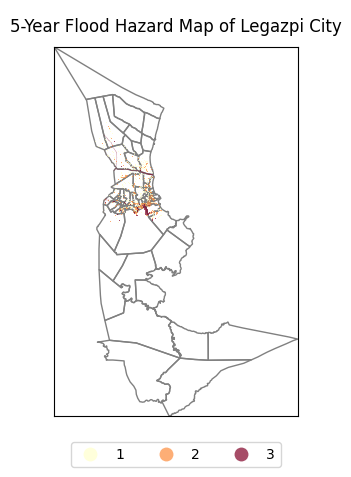

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


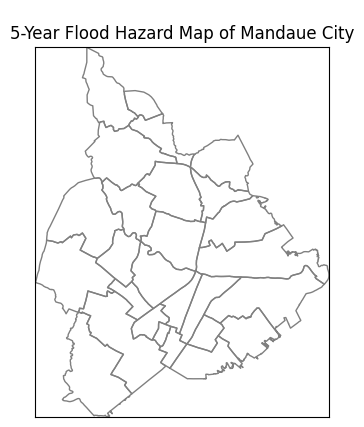

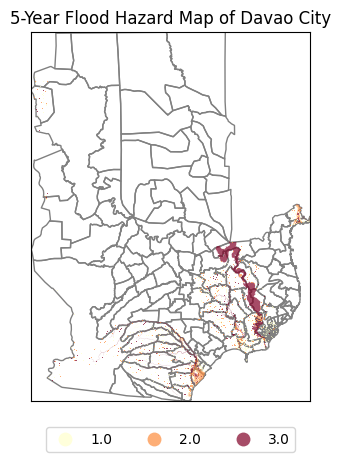

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


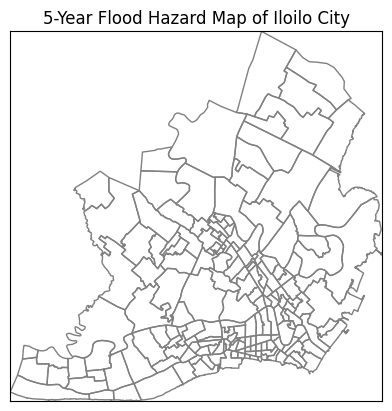

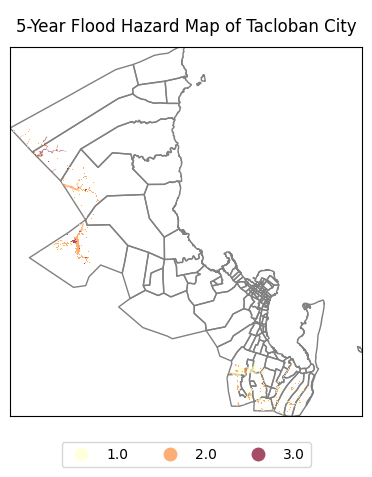

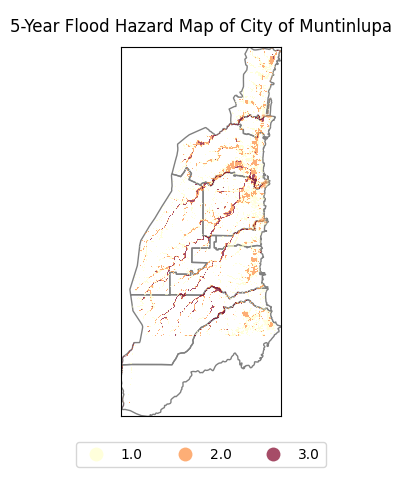

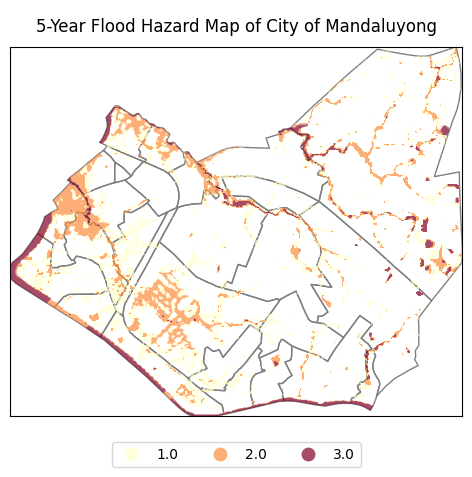

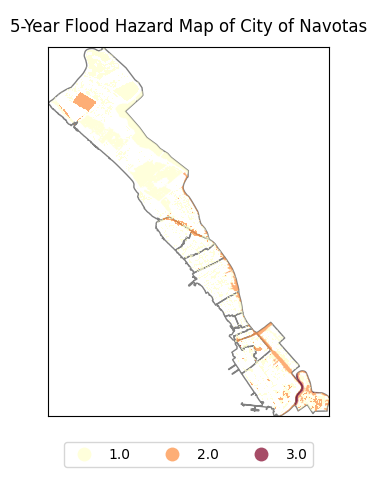

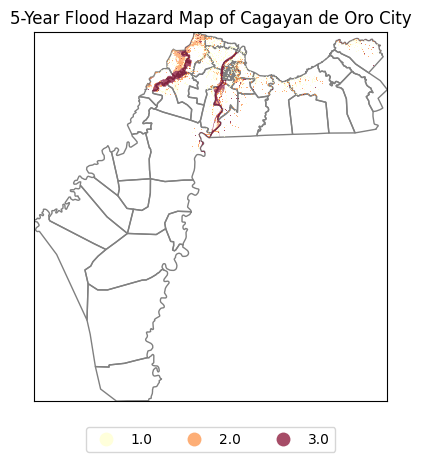

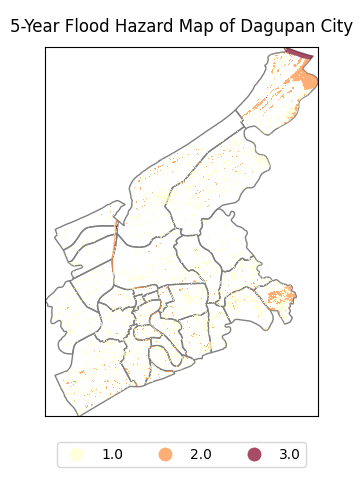

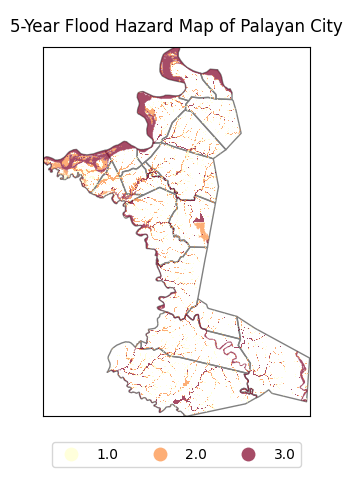

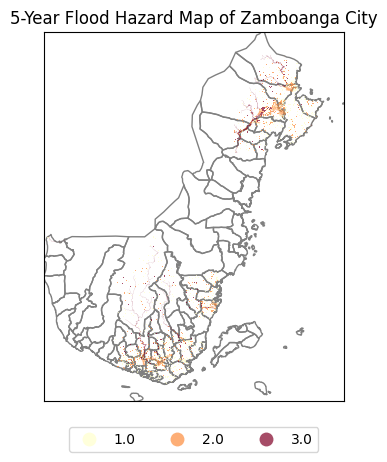

In [ ]:
# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces):
  # print(count,province, lacuna_cities[count])
 
  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial 5-Year Flood Hazard Data 
  fl_hzrd_fn = f'/content/drive/My Drive/Lacuna/FloodHazard/5-year/{province}_Flood_5year.shp'
  fl_hzrd_gdf = gpd.read_file(fl_hzrd_fn).to_crs('EPSG:32651')
  
  # Clip Flood Hazard Data with Lacuna City <i>'s boundary.
  clipped_fl_hzrd_gdf = gpd.clip(fl_hzrd_gdf, city_gdf)

  # Create the figure and axes
  fig, ax = plt.subplots()

  # Plot the Administrative Boundary Basemap (first layer)
  city_gdf.plot(ax=ax, facecolor="none", edgecolor='gray')

  # Crop the visualization to the extent of the first layer
  ax.set_xlim(city_gdf.total_bounds[0], city_gdf.total_bounds[2])
  ax.set_ylim(city_gdf.total_bounds[1], city_gdf.total_bounds[3])
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

  # Plot the second layer (flood hazard)
  clipped_fl_hzrd_gdf.plot(ax=ax, column='Var', categorical=True, cmap='YlOrRd', alpha=0.7, legend=True,
                  legend_kwds={'loc': 'upper center',
                                'bbox_to_anchor' : (0.5, -0.05),
                                'ncol': 3})

  # Set Title
  plt.title("5-Year Flood Hazard Map of "+lacuna_cities[count])

  # Save the figure
  # plt.savefig(f'/content/drive/My Drive/Lacuna/Plots/{lacuna_cities[count]}_Flood_5_year.png')

  # Show the plot
  plt.show()

## E. Landslide Hazard

### 1. Extracting Hazard Level Percent Area

Compute the percent area of each landslide hazard level per baranggay across the Lacuna Cities. 

In [ ]:
# Setup an empty list that will eventually contain all the Lacuna City Dataframes with ammended Landslide Hazard Area Data
city_gdf_list = []
  
# Column Names for Readability
pivot_city_column_names_ls = ['brgy_pct_area_landslide_hazard_low',
                            'brgy_pct_area_landslide_hazard_med', 
                            'brgy_pct_area_landslide_hazard_high']  

# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces[:1]):
  print(count,province, lacuna_cities[count])

  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial 25-Year Landslide Hazard Data 
  ls_hzrd_fn = f'/home/cczablan1/projects/lacuna-fund-climate-health/data/NOAH-Landslide-Hazard/Landslide-Hazard/{province}_LandslideHazards.shp'
  ls_hzrd_gdf = gpd.read_file(ls_hzrd_fn).to_crs('EPSG:32651')

  # Clip Landslide Hazard Data with Lacuna City <i>'s boundary.
  clipped_ls_hzrd_gdf = gpd.clip(ls_hzrd_gdf, city_gdf)

  # Get Intersection of each Hazard with each Baranggay
  overlay_city_ls_hzrd_gdf = gpd.overlay(city_gdf, clipped_ls_hzrd_gdf, how='intersection', keep_geom_type=False)

  # Calculate the area (inkm2) of the resulting intersecting polygons 
  overlay_city_ls_hzrd_gdf['area'] = overlay_city_ls_hzrd_gdf.geometry.area.div(1000000)

  # Aggregate the area of the intersecting polygons by Baranggay using a Pivot Table 
  pivot_city_gdf = overlay_city_ls_hzrd_gdf.pivot_table(index='ADM4_EN', columns='LH', values='area', aggfunc=np.sum)
  


  # Rename Columns for Readability. Note that the values are still in km2.
  pivot_city_gdf.columns = pivot_city_column_names_ls

  # display(pivot_city_gdf)
  
  # Merge the computed pivot table data to the original city administrative data
  city_gdf = city_gdf.merge(pivot_city_gdf, on='ADM4_EN', how='left') 

  # Compute Percent Area out of Baranggay Area
  city_gdf[pivot_city_column_names_ls] = city_gdf[pivot_city_column_names_ls].div(city_gdf.brgy_total_area_sqkm, axis=0)*100
  # display(city_gdf.iloc[:,10:])

  # Add city data to list of city dataframes
  city_gdf_list.append(city_gdf)

# Concatenate Lists of Lacuna City with Hazard Data Dataframes
ls_gdf = pd.concat(city_gdf_list)
ls_gdf.head()


0 Albay Legazpi City


,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,brgy_total_area_sqkm,brgy_pct_area_landslide_hazard_low,brgy_pct_area_landslide_hazard_med,brgy_pct_area_landslide_hazard_high
0,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 45 - Dita (Bgy. 51),PH050506053,"POLYGON ((579752.343 1458208.276, 580219.811 1...",0.8428,NaN,NaN,NaN
1,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 62 - Homapon (Bgy. 55),PH050506056,"POLYGON ((582204.624 1447546.937, 582206.580 1...",7.0818,10.134472,7.927245,1.919271
2,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 10 - Cabugao,PH050506072,"POLYGON ((579556.773 1452590.900, 579560.114 1...",0.0335,NaN,NaN,NaN
3,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 23 - Imperial Court Subd. (Pob.),PH050506020,"POLYGON ((581731.582 1452914.659, 581758.664 1...",0.0621,NaN,NaN,NaN
4,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 40 - Cruzada (Bgy. 52),PH050506051,"POLYGON ((580282.649 1455133.588, 580380.407 1...",1.4442,NaN,NaN,NaN


### 2. Plotting Landslide Hazard Maps

/home/cczablan1/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/home/cczablan1/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


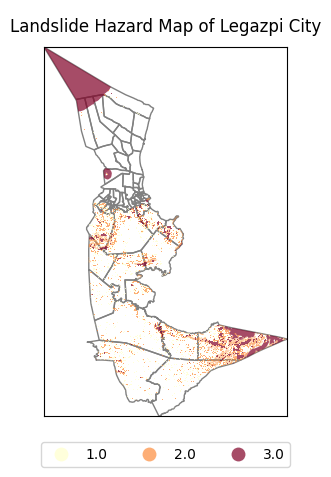

In [ ]:
# Create a loop across all Lacuna Cities
for count, province in enumerate(lacuna_provinces[:1]):
  # print(count,province, lacuna_cities[count])
 
  # Select Lacuna City <i> from Administrative Boundary Data
  city_gdf = adm_gdf[adm_gdf["ADM3_EN"] == lacuna_cities[count]]

  # Read Provincial Landslide Hazard Data 
  ls_hzrd_fn = f'/home/cczablan1/projects/lacuna-fund-climate-health/data/NOAH-Landslide-Hazard/Landslide-Hazard/{province}_LandslideHazards.shp'
  ls_hzrd_gdf = gpd.read_file(ls_hzrd_fn).to_crs('EPSG:32651')
  
  # Clip Landslide Hazard Data with Lacuna City <i>'s boundary.
  clipped_ls_hzrd_gdf = gpd.clip(ls_hzrd_gdf, city_gdf)

  # Create the figure and axes
  fig, ax = plt.subplots()

  # Plot the Administrative Boundary Basemap (first layer)
  city_gdf.plot(ax=ax, facecolor="none", edgecolor='gray')

  # Crop the visualization to the extent of the first layer
  ax.set_xlim(city_gdf.total_bounds[0], city_gdf.total_bounds[2])
  ax.set_ylim(city_gdf.total_bounds[1], city_gdf.total_bounds[3])
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

  # Plot the second layer (Landslide hazard)
  clipped_ls_hzrd_gdf.plot(ax=ax, column='LH', categorical=True, cmap='YlOrRd', alpha=0.7, legend=True,
                  legend_kwds={'loc': 'upper center',
                                'bbox_to_anchor' : (0.5, -0.05),
                                'ncol': 3})

  # Set Title
  plt.title("Landslide Hazard Map of "+lacuna_cities[count])

  # Save the figure
  # plt.savefig(f'/content/drive/My Drive/Lacuna/Plots/{lacuna_cities[count]}_Landslide_5_year.png')

  # Show the plot
  plt.show()

# III. Merging all Hazard Data

Merge all hazard percent area data from NOAH Flood Hazard (100yr, 25yr, 5yr) and Landslide Hazard Data

In [ ]:
# Merge Hazard Percent Area Data (from 100-year, 25-year, 5-year Flood Hazard to Landslide Hazazrd)
fl_100_25_gdf = pd.merge(fl_100_year_gdf, fl_25_year_gdf[['ADM4_PCODE']+pivot_city_column_names_25yr_fl], on="ADM4_PCODE", how="left",)
fl_100_25_5_gdf = pd.merge(fl_100_25_gdf, fl_5_year_gdf[['ADM4_PCODE']+pivot_city_column_names_5yr_fl], on="ADM4_PCODE", how="left",)
all_hazards_gdf = pd.merge(fl_100_25_5_gdf, ls_gdf[['ADM4_PCODE']+pivot_city_column_names_ls], on="ADM4_PCODE", how="left",)

# Fill NaN Hazard Percent Area Data values 
all_hazards_gdf.iloc[:,10:] = all_hazards_gdf.iloc[:,10:].fillna(0).round(4)
all_hazards_gdf.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry,brgy_area,...,100_fl_3,25_fl_1,25_fl_2,25_fl_3,5_fl_1,5_fl_2,5_fl_3,ls_1,ls_2,ls_3
0,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 45 - Dita (Bgy. 51),PH050506053,"POLYGON ((579752.343 1458208.276, 580219.811 1...",8.427579e+05,...,764.614687,1.715430e+04,4825.645689,500.000000,11588.239585,3217.535600,300.000000,NaN,NaN,NaN
1,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 62 - Homapon (Bgy. 55),PH050506056,"POLYGON ((582204.624 1447546.937, 582206.580 1...",7.081824e+06,...,461356.509563,NaN,NaN,NaN,NaN,NaN,NaN,7.177030e+05,5.613916e+05,1.359189e+05
2,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 10 - Cabugao,PH050506072,"POLYGON ((579556.773 1452590.900, 579560.114 1...",3.352368e+04,...,NaN,1.096331e+03,600.000000,NaN,831.084685,400.000000,NaN,NaN,NaN,NaN
3,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 23 - Imperial Court Subd. (Pob.),PH050506020,"POLYGON ((581731.582 1452914.659, 581758.664 1...",6.212371e+04,...,14182.356858,1.072322e+04,43852.316711,3666.090606,12981.101363,32048.593635,NaN,NaN,NaN,NaN
4,Region V,PH050000000,Albay,PH050500000,Legazpi City,PH050506000,Bgy. 40 - Cruzada (Bgy. 52),PH050506051,"POLYGON ((580282.649 1455133.588, 580380.407 1...",1.444231e+06,...,1711.158535,1.991524e+05,65718.875168,687.757321,139076.265273,43070.579836,586.444339,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,Region IX,PH090000000,Zamboanga del Sur,PH097300000,Zamboanga City,PH097332000,Guisao,PH097332030,"POLYGON ((406937.913 774410.093, 406973.096 77...",4.062278e+06,...,298405.272439,NaN,NaN,NaN,NaN,NaN,NaN,3.018358e+05,6.635604e+05,2.218327e+04
875,Region IX,PH090000000,Zamboanga del Sur,PH097300000,Zamboanga City,PH097332000,Panubigan,PH097332057,"MULTIPOLYGON (((417677.960 789198.420, 417683....",5.179852e+06,...,3237.471112,NaN,NaN,NaN,NaN,NaN,NaN,5.779044e+05,1.132972e+06,4.999885e+01
876,Region IX,PH090000000,Zamboanga del Sur,PH097300000,Zamboanga City,PH097332000,Cawit,PH097332022,"MULTIPOLYGON (((386930.112 768611.576, 386936....",3.369639e+06,...,61020.987539,NaN,NaN,NaN,NaN,NaN,NaN,2.836682e+05,5.931920e+05,4.775000e+03
877,Region IX,PH090000000,Zamboanga del Sur,PH097300000,Zamboanga City,PH097332000,Tagasilay,PH097332081,"POLYGON ((419082.831 808520.505, 419346.216 80...",1.783177e+07,...,900967.885722,2.693119e+05,239403.789307,376370.334070,250281.167622,192247.464980,287454.062857,1.954073e+06,5.733233e+06,1.534397e+06


In [ ]:
# Export
all_hazards_gdf.to_crs('EPSG:4326').to_file("/content/drive/My Drive/Lacuna/Barangay Hazard Table/hz_proportion.json", driver="GeoJSON")
all_hazards_gdf.drop(['geometry'], axis=1).to_csv('/content/drive/My Drive/Lacuna/Barangay Hazard Table/hz_proportion.csv', encoding='utf-8')

In [ ]:
# # Read Administrative Boundary Data
# hz_in_percent_fn = '/content/drive/My Drive/Lacuna/Barangay Hazard Table/hz_proportion.json'
# hz_in_percent = gpd.read_file(hz_in_percent_fn)

In [ ]:
# hz_in_percent.rename(columns = {'brgy_prop_area_flood_hazard_5yr_low':'brgy_pct_area_flood_hazard_5yr_low',
#                                 'brgy_prop_area_flood_hazard_5yr_med':'brgy_pct_area_flood_hazard_5yr_med',
#                                 'brgy_prop_area_flood_hazard_5yr_high':'brgy_pct_area_flood_hazard_5yr_high',
#                                 'brgy_prop_area_flood_hazard_25yr_low':'brgy_pct_area_flood_hazard_25yr_low',
#                                 'brgy_prop_area_flood_hazard_25yr_med':'brgy_pct_area_flood_hazard_25yr_med',
#                                 'brgy_prop_area_flood_hazard_25yr_high':'brgy_pct_area_flood_hazard_25yr_high',
#                                 'brgy_prop_area_flood_hazard_100yr_low':'brgy_pct_area_flood_hazard_100yr_low',
#                                 'brgy_prop_area_flood_hazard_100yr_med':'brgy_pct_area_flood_hazard_100yr_med',
#                                 'brgy_prop_area_flood_hazard_100yr_high':'brgy_pct_area_flood_hazard_100yr_high',
#                                 'brgy_prop_area_landslide_hazard_low':'brgy_pct_area_landslide_hazard_low',
#                                 'brgy_prop_area_landslide_hazard_med':'brgy_pct_area_landslide_hazard_med',
#                                 'brgy_prop_area_landslide_hazard_high':'brgy_pct_area_landslide_hazard_high',}, inplace = True)

# hz_in_percent["brgy_total_area_sqkm"] = (hz_in_percent["brgy_area"] / 1000000).round(4)

In [ ]:
# hz_in_percent.iloc[:,10:] = hz_in_percent.iloc[:,10:].round(4).fillna(0)
# hz_in_percent["brgy_total_area_sqkm"] = (hz_in_percent["brgy_area"] / 1000000).round(4)

# hz_in_percent.rename(columns = {'5_fl_1':'brgy_pct_area_flood_hazard_5yr_low',
#                                 '5_fl_2':'brgy_pct_area_flood_hazard_5yr_med',
#                                 '5_fl_3':'brgy_pct_area_flood_hazard_5yr_high',
#                                 '25_fl_1':'brgy_pct_area_flood_hazard_25yr_low',
#                                 '25_fl_2':'brgy_pct_area_flood_hazard_25yr_med',
#                                 '25_fl_3':'brgy_pct_area_flood_hazard_25yr_high',
#                                 '100_fl_1':'brgy_pct_area_flood_hazard_100yr_low',
#                                 '100_fl_2':'brgy_pct_area_flood_hazard_100yr_med',
#                                 '100_fl_3':'brgy_pct_area_flood_hazard_100yr_high',
#                                 'ls_1':'brgy_pct_area_landslide_hazard_low',
#                                 'ls_2':'brgy_pct_area_landslide_hazard_med',
#                                 'ls_3':'brgy_pct_area_landslide_hazard_high',}, inplace = True)
